### 1. Setup & Imports

In [1]:
import os
import sys
from pathlib import Path
from dotenv import load_dotenv
import warnings
warnings.filterwarnings('ignore')

# Load environment variables
load_dotenv()

# Add project root to path
project_root = Path.cwd().parent if 'notebooks' in str(Path.cwd()) else Path.cwd()
sys.path.insert(0, str(project_root))

print("Environment loaded")
print(f"📁 Project root: {project_root}")


Environment loaded
📁 Project root: /Users/kaushik003/Documents/projects/agri-chatbot


In [2]:
# Core imports
import json
from typing import List, Dict, Any, Tuple
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# PDF processing
import pypdf
import pdfplumber

# LangChain
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document

# Utilities
import tiktoken
from tqdm.auto import tqdm
import numpy as np

print("All imports successful")

All imports successful


### 2. Configuration

In [4]:
# Document paths
DATA_DIR = project_root / "data"
DISEASE_PDF = DATA_DIR / "CitrusPlantPestsAndDiseases.pdf"
SCHEME_PDF = DATA_DIR / "GovernmentSchemes.pdf"

# Verify data directory
if not DATA_DIR.exists():
    DATA_DIR.mkdir(parents=True)
    print(f" Created data directory: {DATA_DIR}")
    print("Please add the PDF files to the data/ directory")
else:
    print(f" Data directory exists: {DATA_DIR}")

# Check for PDFs
pdfs_found = []
if DISEASE_PDF.exists():
    print(f" Found: {DISEASE_PDF.name}")
    pdfs_found.append("disease")
else:
    print(f" Missing: {DISEASE_PDF.name}")

if SCHEME_PDF.exists():
    print(f"Found: {SCHEME_PDF.name}")
    pdfs_found.append("scheme")
else:
    print(f" Missing: {SCHEME_PDF.name}")

if not pdfs_found:
    print("\n No PDFs found!")

 Data directory exists: /Users/kaushik003/Documents/projects/agri-chatbot/data
 Found: CitrusPlantPestsAndDiseases.pdf
Found: GovernmentSchemes.pdf


### 3. Load and Explore PDFs

#### 3.1 PDF Loading Functions

In [5]:
def load_pdf_pypdf(pdf_path: Path) -> List[Dict[str, Any]]:
    """Load PDF using PyPDF"""
    documents = []
    
    try:
        with open(pdf_path, 'rb') as file:
            pdf_reader = pypdf.PdfReader(file)
            num_pages = len(pdf_reader.pages)
            
            print(f" Total pages: {num_pages}")
            
            for page_num in tqdm(range(num_pages), desc="Loading pages"):
                page = pdf_reader.pages[page_num]
                text = page.extract_text()
                
                if text and text.strip():  # Only add non-empty pages
                    documents.append({
                        "page_number": page_num + 1,
                        "text": text,
                        "source": pdf_path.name,
                        "char_count": len(text)
                    })
        
        return documents
    
    except Exception as e:
        print(f" Error loading {pdf_path.name}: {e}")
        return []

def load_pdf_pdfplumber(pdf_path: Path) -> List[Dict[str, Any]]:
    """Alternative: Load PDF using pdfplumber (better text extraction)"""
    documents = []
    
    try:
        with pdfplumber.open(pdf_path) as pdf:
            num_pages = len(pdf.pages)
            print(f" Total pages: {num_pages}")
            
            for page_num in tqdm(range(num_pages), desc="Loading pages"):
                page = pdf.pages[page_num]
                text = page.extract_text()
                
                if text and text.strip():
                    documents.append({
                        "page_number": page_num + 1,
                        "text": text,
                        "source": pdf_path.name,
                        "char_count": len(text)
                    })
        
        return documents
    
    except Exception as e:
        print(f"Error loading {pdf_path.name}: {e}")
        return []

print("PDF loading functions defined")

PDF loading functions defined


#### 3.2 Load Disease PDF

In [6]:
disease_docs = []

if DISEASE_PDF.exists():
    print("Loading CitrusPlantPestsAndDiseases.pdf...")
    print("\nTrying PyPDF first...")
    disease_docs = load_pdf_pypdf(DISEASE_PDF)
    
    # If PyPDF fails or gives poor results, trying pdfplumber
    if not disease_docs or len(disease_docs) < 10:
        print("\nPyPDF results not satisfactory, trying pdfplumber...")
        disease_docs = load_pdf_pdfplumber(DISEASE_PDF)
    
    if disease_docs:
        print(f"\n Successfully loaded {len(disease_docs)} pages")
        print(f" Total characters: {sum(doc['char_count'] for doc in disease_docs):,}")
        print(f"\n First page preview (first 500 chars):")
        print("-" * 80)
        print(disease_docs[0]["text"][:500])
        print("-" * 80)
    else:
        print("Failed to load disease PDF")
else:
    print(" Disease PDF not found. Skipping...")

Loading CitrusPlantPestsAndDiseases.pdf...

Trying PyPDF first...
 Total pages: 67


Loading pages:   0%|          | 0/67 [00:00<?, ?it/s]


 Successfully loaded 67 pages
 Total characters: 181,749

 First page preview (first 500 chars):
--------------------------------------------------------------------------------
Comprehensive Guide to Citrus Diseases, Pests, 
and Disorders in India 
Introduction 
Citrus (including sweet oranges, mandarins, lemons, and limes) is a vital fruit crop for Indian 
farmers, especially in states like Telangana, Andhra Pradesh, Maharashtra, and the Northeast. 
Citrus trees, however, are vulnerable to a wide array of diseases, pests, nutrient deficiencies, 
and physiological disorders. These issues can severely impact yield – for example, 
Huanglongbing (citrus greening) alone ca
--------------------------------------------------------------------------------


#### 3.3 Load Government Schemes PDF

In [7]:
scheme_docs = []

if SCHEME_PDF.exists():
    print(" Loading GovernmentSchemes.pdf...")
    print("\nTrying PyPDF first...")
    scheme_docs = load_pdf_pypdf(SCHEME_PDF)
    
    # If PyPDF fails or gives poor results, try pdfplumber
    if not scheme_docs or len(scheme_docs) < 5:
        print("\nPyPDF results not satisfactory, trying pdfplumber...")
        scheme_docs = load_pdf_pdfplumber(SCHEME_PDF)
    
    if scheme_docs:
        print(f"\n Successfully loaded {len(scheme_docs)} pages")
        print(f" Total characters: {sum(doc['char_count'] for doc in scheme_docs):,}")
        print(f"\n First page preview (first 500 chars):")
        print("-" * 80)
        print(scheme_docs[0]["text"][:500])
        print("-" * 80)
    else:
        print("Failed to load scheme PDF")
else:
    print(" Scheme PDF not found. Skipping...")

 Loading GovernmentSchemes.pdf...

Trying PyPDF first...
 Total pages: 63


Loading pages:   0%|          | 0/63 [00:00<?, ?it/s]


 Successfully loaded 63 pages
 Total characters: 76,781

 First page preview (first 500 chars):
--------------------------------------------------------------------------------
A Complete Guide to Subsidies, Assistance Programs, and Financial Bene ts -
Extended Edition
Sweet orange or mosambi cultivation has emerged as one of the most lucrative horticulture
enterprises in Andhra Pradesh and Telangana. Both state governments, along with the
Government of India, have implemented over 30 comprehensive schemes to support
mosambi farmers through all stages of cultivation—from plantation assistance, subsidies,
and insurance coverage to credit facilities, market linkages, and
--------------------------------------------------------------------------------


### 4. Text Analysis & Statistics

In [8]:
def count_tokens(text: str, model: str = "gpt-3.5-turbo") -> int:
    """Count tokens in text using tiktoken"""
    try:
        encoding = tiktoken.encoding_for_model(model)
        return len(encoding.encode(text))
    except:
        return int(len(text.split()) / 0.75)  # Fallback approximation

print(" Token counting function ready")

 Token counting function ready


In [9]:
# Analyze Disease PDF
if disease_docs:
    disease_tokens = [count_tokens(doc["text"]) for doc in disease_docs]
    disease_stats = {
        "total_pages": len(disease_docs),
        "total_tokens": sum(disease_tokens),
        "avg_tokens": np.mean(disease_tokens),
        "min_tokens": min(disease_tokens),
        "max_tokens": max(disease_tokens)
    }
    print(" Disease PDF:")
    print(f"   Pages: {disease_stats['total_pages']}")
    print(f"   Total tokens: {disease_stats['total_tokens']:,}")
    print(f"   Avg tokens/page: {disease_stats['avg_tokens']:.0f}\n")

# Analyze Scheme PDF
if scheme_docs:
    scheme_tokens = [count_tokens(doc["text"]) for doc in scheme_docs]
    scheme_stats = {
        "total_pages": len(scheme_docs),
        "total_tokens": sum(scheme_tokens),
        "avg_tokens": np.mean(scheme_tokens),
        "min_tokens": min(scheme_tokens),
        "max_tokens": max(scheme_tokens)
    }
    print(" Scheme PDF:")
    print(f"   Pages: {scheme_stats['total_pages']}")
    print(f"   Total tokens: {scheme_stats['total_tokens']:,}")
    print(f"   Avg tokens/page: {scheme_stats['avg_tokens']:.0f}")

 Disease PDF:
   Pages: 67
   Total tokens: 44,629
   Avg tokens/page: 666

 Scheme PDF:
   Pages: 63
   Total tokens: 22,751
   Avg tokens/page: 361


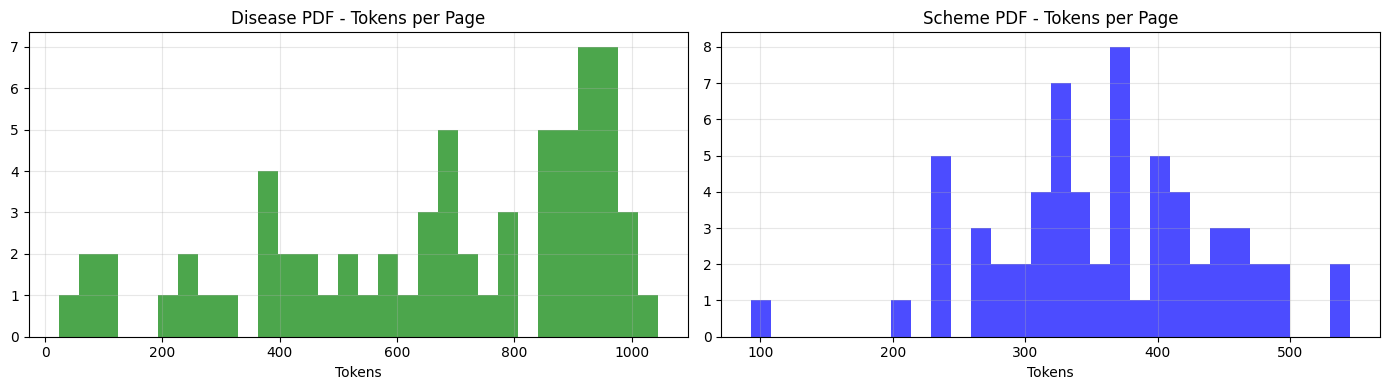

In [10]:
if disease_docs or scheme_docs:
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    
    if disease_docs:
        axes[0].hist([count_tokens(d["text"]) for d in disease_docs], bins=30, color='green', alpha=0.7)
        axes[0].set_title('Disease PDF - Tokens per Page')
        axes[0].set_xlabel('Tokens')
        axes[0].grid(alpha=0.3)
    
    if scheme_docs:
        axes[1].hist([count_tokens(d["text"]) for d in scheme_docs], bins=30, color='blue', alpha=0.7)
        axes[1].set_title('Scheme PDF - Tokens per Page')
        axes[1].set_xlabel('Tokens')
        axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### 5. Chunking Strategy Experiments

In [11]:
CHUNK_CONFIGS = [
    {"name": "Small", "size": 500, "overlap": 100},
    {"name": "Medium", "size": 800, "overlap": 150},
    {"name": "Large", "size": 1000, "overlap": 200},
]

print(" Testing 3 chunking strategies:")
for c in CHUNK_CONFIGS:
    print(f"   {c['name']:8} - Size: {c['size']:4}, Overlap: {c['overlap']}")

 Testing 3 chunking strategies:
   Small    - Size:  500, Overlap: 100
   Medium   - Size:  800, Overlap: 150
   Large    - Size: 1000, Overlap: 200


In [13]:
def test_chunking(docs: List[Dict], size: int, overlap: int) -> Tuple[List[Document], Dict]:
    """Test chunking and return chunks + stats"""
    full_text = "\n\n".join([doc["text"] for doc in docs])
    
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=size,
        chunk_overlap=overlap,
        length_function=len,
        separators=["\n\n", "\n", ". ", " ", ""]
    )
    
    chunks = splitter.split_text(full_text)
    documents = [Document(page_content=c, metadata={"chunk_id": i, "source": docs[0]["source"]}) 
                 for i, c in enumerate(chunks)]
    
    tokens = [count_tokens(d.page_content) for d in documents]
    stats = {
        "num_chunks": len(documents),
        "avg_tokens": np.mean(tokens),
        "std_tokens": np.std(tokens),
        "min_tokens": min(tokens),
        "max_tokens": max(tokens)
    }
    
    return documents, stats

print(" Chunking test function ready")

 Chunking test function ready


In [14]:
if disease_docs:
    print("Testing Disease PDF chunking:\n")
    disease_results = {}
    
    for config in CHUNK_CONFIGS:
        chunks, stats = test_chunking(disease_docs, config['size'], config['overlap'])
        disease_results[config['name']] = {"chunks": chunks, "stats": stats}
        
        print(f"{config['name']:8} → {stats['num_chunks']} chunks, "
              f"avg {stats['avg_tokens']:.0f} tokens (±{stats['std_tokens']:.0f})")

Testing Disease PDF chunking:

Small    → 494 chunks, avg 107 tokens (±21)
Medium   → 297 chunks, avg 168 tokens (±42)
Large    → 245 chunks, avg 213 tokens (±50)


In [15]:
if scheme_docs:
    print("Testing Scheme PDF chunking:\n")
    scheme_results = {}
    
    for config in CHUNK_CONFIGS:
        chunks, stats = test_chunking(scheme_docs, config['size'], config['overlap'])
        scheme_results[config['name']] = {"chunks": chunks, "stats": stats}
        
        print(f"{config['name']:8} → {stats['num_chunks']} chunks, "
              f"avg {stats['avg_tokens']:.0f} tokens (±{stats['std_tokens']:.0f})")

Testing Scheme PDF chunking:

Small    → 213 chunks, avg 123 tokens (±48)
Medium   → 132 chunks, avg 192 tokens (±72)
Large    → 112 chunks, avg 224 tokens (±90)


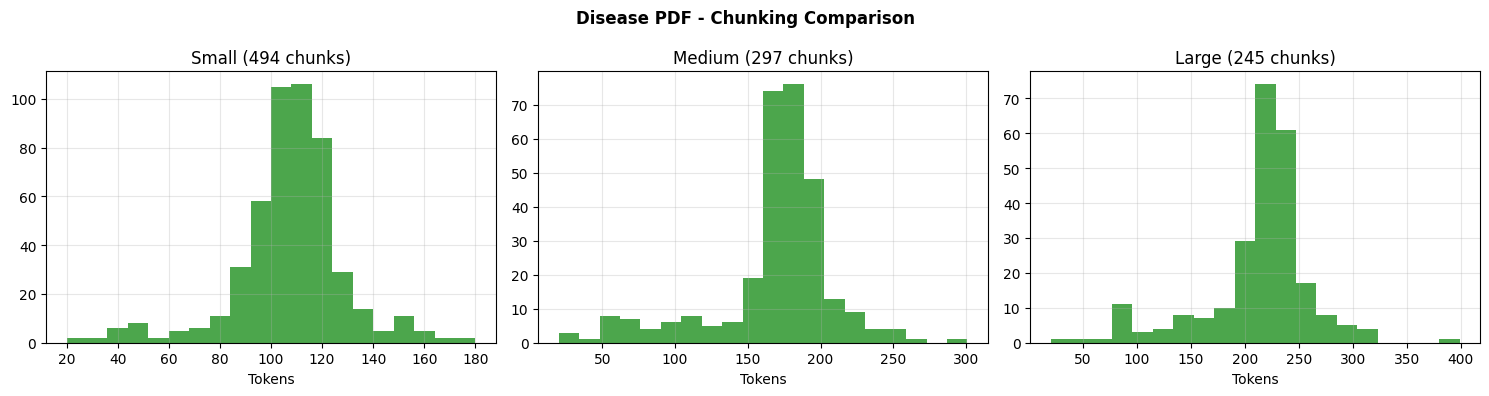

In [16]:
if disease_docs and disease_results:
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle('Disease PDF - Chunking Comparison', fontweight='bold')
    
    for idx, (name, result) in enumerate(disease_results.items()):
        tokens = [c.metadata.get('token_count', count_tokens(c.page_content)) 
                  for c in result['chunks']]
        axes[idx].hist(tokens, bins=20, color='green', alpha=0.7)
        axes[idx].set_title(f"{name} ({len(tokens)} chunks)")
        axes[idx].set_xlabel('Tokens')
        axes[idx].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [17]:
OPTIMAL_CONFIG = {"name": "Medium", "size": 800, "overlap": 150}

print(" Selected Optimal Configuration:")
print(f"   Size: {OPTIMAL_CONFIG['size']} chars")
print(f"   Overlap: {OPTIMAL_CONFIG['overlap']} chars")
print(f"\n Reasoning:")
print(f"   • ~150-200 tokens per chunk (good context)")
print(f"   • 150 char overlap ensures continuity")
print(f"   • Balance granularity & context")

 Selected Optimal Configuration:
   Size: 800 chars
   Overlap: 150 chars

 Reasoning:
   • ~150-200 tokens per chunk (good context)
   • 150 char overlap ensures continuity
   • Balance granularity & context
